In [5]:
from kiara.interfaces.python_api import Step
from kiara.utils.jupyter import graph_to_image

import_folder = Step("onboarding.folder.import", step_id="import_folder")
# import_folder.input.path = "/home/markus/projects/dharpa/notebooks/TopicModelling/data_tm_workflow"

create_table_config = {"columns": ["id", "rel_path", "file_name", "content"]}
create_table = Step(
    "table.from_file_bundle",
    module_config=create_table_config,
    step_id="create_table",
)
create_table.input.files = import_folder.output.file_bundle

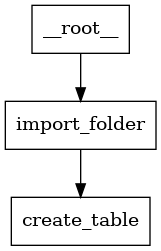

In [6]:
graph_to_image(create_table.workflow.structure.execution_graph)

In [7]:
extract_date = Step(
    "array.map",
    module_config={"module_type": "date.extract_from_string"},
    step_id="extract_date",
)
extract_date.input.array = create_table.output.table.file_name

regex_module = {
    "module_type": "string.match_regex",
    "module_config": {
        "regex": "(\\w+\\d+)_\\d{4}-\\d{2}-\\d{2}_",
        "only_first_match": True,
    },
}
extract_ref = Step("array.map", module_config=regex_module, step_id="extract_ref")
extract_ref.input.array = create_table.output.table.file_name

repl_module = {
    "module_type": "string.replace",
    "module_config": {
        "replacement_map": {
            "sn85066408": "L\\'Italia",
            "2012271201": "Cronaca Sovversiva",
        }
    },
}
lookup_publication_name = Step(
    "array.map", module_config=repl_module, step_id="lookup_publication"
)
lookup_publication_name.input.array = extract_ref.output.array

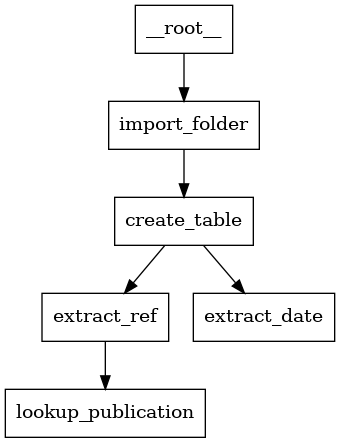

In [8]:
graph_to_image(create_table.workflow.structure.execution_graph)

In [9]:
tokenize_text = Step(
    "array.map",
    module_config={
        "module_type": "language.tokens.tokenize_text",
        "input_name": "text",
    },
    step_id="tokenize_text",
)
tokenize_text.input.array = create_table.output.table.content

merge_table = Step("table.merge")
merge_table.input.sources = [
    create_table.output.table,
    extract_date.output.array,
    extract_ref.output.array,
    lookup_publication_name.output.array,
    tokenize_text.output.array,
]

date_range_check = Step(
    "array.map",
    module_config={"module_type": "date.range_check", "input_name": "date"},
    step_id="create_data_range_filter",
)
date_range_check.input.array = extract_date.output.array

filter_table = Step("table.filter.with_mask", step_id="filtered_table")
filter_table.input.table = merge_table.output.table
filter_table.input.mask = date_range_check.output.array

tokenize_config = {
    "module_type": "language.tokens.tokenize_text",
    "input_name": "text",
}
tokenize_text = Step(
    "array.map", module_config=tokenize_config, step_id="tokenize_corpus"
)
tokenize_text.input.array = filter_table.output.table.content

remove_stopwords = Step(
    "language.tokens.remove_stopwords", step_id="remove_stopwords"
)
remove_stopwords.input.token_lists = tokenize_text.output.array

lemmatize = Step("language.lemmatize.tokens_array", step_id="lemmatize_corpus")
lemmatize.input.tokens_array = remove_stopwords.output.token_list

lda = Step("language.lda.LDA", step_id="generate_lda")
lda.input.tokens_array = lemmatize.output.tokens_array

import_folder.input.path = (
    "/home/markus/projects/dharpa/notebooks/TopicModelling/data_tm_workflow"
)
date_range_check.input.earliest = "1918-01-01"

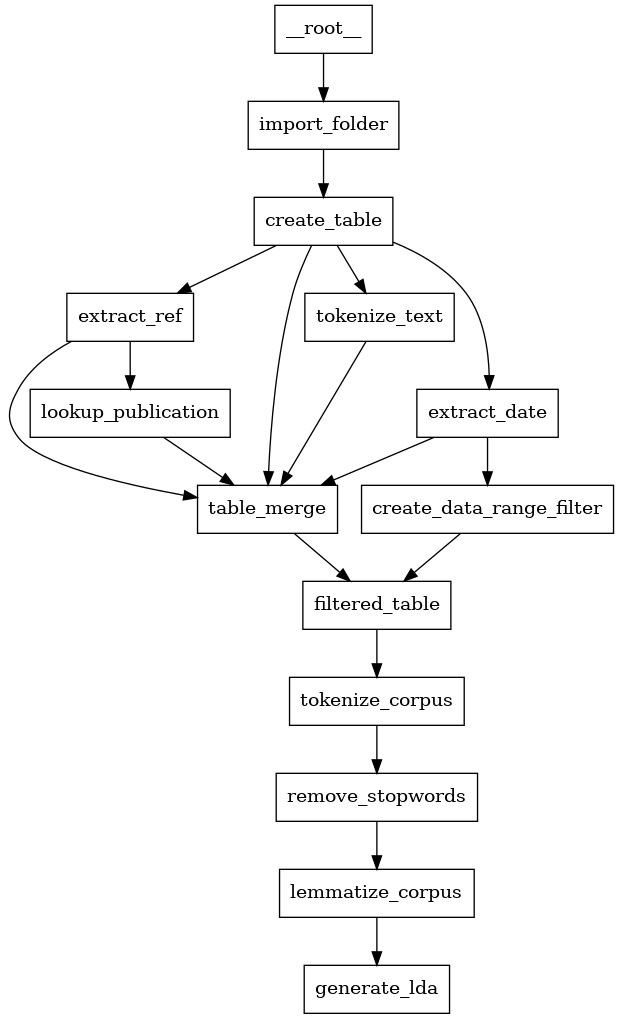

In [10]:
graph_to_image(create_table.workflow.structure.execution_graph)